In [ ]:
!pip install -q google-cloud-bigquery pyspark

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

service_account_json = "firm-crossing-403315-97b3027f0ac4.json"
client = bigquery.Client.from_service_account_json(service_account_json)

In [ ]:
query = """
    SELECT date, hour, lat, long, signal, net, speed, status, activity
    FROM `bigquery-public-data.catalonian_mobile_coverage_eu.mobile_data_2015_2017`
    WHERE speed is not null and date between '2015-01-01' and '2015-12-31'
"""

# Rezultate într-un DataFrame Pandas
query_job = client.query(query)
df = query_job.result().to_dataframe()

print(df.head())

         date      hour       lat     long  signal net  speed  status activity
0  2015-03-05  09:03:16  41.37010  2.08559      26  4G    0.5       2  ON_FOOT
1  2015-03-05  09:13:51  41.37047  2.08528      31  3G    5.7       2    STILL
2  2015-03-05  07:52:28  41.52209  2.19405      13  3G    2.9       2  ON_FOOT
3  2015-03-05  08:00:40  41.51893  2.19199       9  3G   15.3       2  TILTING
4  2015-03-05  20:54:04  41.53462  2.18078       8  3G   12.5       2  UNKNOWN


In [ ]:
df['hour'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str))

# initializare sesiunea Spark
spark = SparkSession.builder.appName("BigQueryAnalysis").getOrCreate()

# convertire DataFrame-ul Pandas in DataFrame Spark
spark_df = spark.createDataFrame(df)
spark_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- signal: long (nullable = true)
 |-- net: string (nullable = true)
 |-- speed: double (nullable = true)
 |-- status: long (nullable = true)
 |-- activity: string (nullable = true)



In [ ]:
# agregare date pentru a calcula media `signal` și `speed` pe tip retea si activitate
agg_df = spark_df.groupBy("net", "activity").agg(
    {"signal": "avg", "speed": "avg"}
).withColumnRenamed("avg(signal)", "avg_signal").withColumnRenamed("avg(speed)", "avg_speed")

agg_df.show()

+----+----------+------------------+------------------+
| net|  activity|        avg_signal|         avg_speed|
+----+----------+------------------+------------------+
|  4G|   ON_FOOT|14.728376181200598| 4.370909061639471|
|NULL|IN_VEHICLE|10.855550465719958|50.343296686517135|
|NULL|   TILTING|  9.26610377230015|10.876154160424862|
|  4G|     STILL|14.601511433088703|  7.10355322462608|
|NULL|   ON_FOOT| 9.186380882646608| 5.455002329761011|
|  2G|IN_VEHICLE|12.717134199036664| 49.92083610269164|
|  3G|ON_BICYCLE| 14.19416956405456|19.585956381142324|
|  4G|   TILTING| 14.55264023934181| 8.190219895287694|
|  2G|     STILL|12.527229304719297|  6.93760772309833|
|  2G|ON_BICYCLE|12.840086802130598| 16.04529492996648|
|  2G|   UNKNOWN| 12.42449349863925| 7.051130329604031|
|  3G|IN_VEHICLE|13.461323194736758| 48.52233510752661|
|  4G|   UNKNOWN|14.531717700998854| 6.559420337317912|
|  3G|     STILL|13.720325469027818| 7.822623366474459|
|NULL|   UNKNOWN| 8.868484042553192| 7.597114361

In [ ]:
from pyspark.sql.functions import max

# Calculam valorile maxime pentru 'speed' și 'signal'
max_values = spark_df.agg(
    max("speed").alias("maxspeed"),
    max("signal").alias("maxsignal")
)

max_values.show()

+--------+---------+
|maxspeed|maxsignal|
+--------+---------+
|   255.0|       99|
+--------+---------+



In [ ]:
from pyspark.sql.functions import when, isnull, lit

# inlocuire valorile null de pe coloana 'net' cu '3G'
agg_df = agg_df.withColumn("net", when(isnull("net"), "3G").otherwise(agg_df["net"]))

# inlocuire valorile null de pe coloanele 'avg_speed' și 'avg_signal' cu 0
agg_df = agg_df.withColumn("avg_speed", when(isnull("avg_speed"), 0).otherwise(agg_df["avg_speed"]))
agg_df = agg_df.withColumn("avg_signal", when(isnull("avg_signal"), 0).otherwise(agg_df["avg_signal"]))

agg_df.show()

+---+----------+------------------+------------------+
|net|  activity|        avg_signal|         avg_speed|
+---+----------+------------------+------------------+
| 4G|   ON_FOOT|14.728376181200598| 4.370909061639471|
| 3G|IN_VEHICLE|10.855550465719958|50.343296686517135|
| 3G|   TILTING|  9.26610377230015|10.876154160424862|
| 4G|     STILL|14.601511433088703|  7.10355322462608|
| 3G|   ON_FOOT| 9.186380882646608| 5.455002329761011|
| 2G|IN_VEHICLE|12.717134199036664| 49.92083610269164|
| 3G|ON_BICYCLE| 14.19416956405456|19.585956381142324|
| 4G|   TILTING| 14.55264023934181| 8.190219895287694|
| 2G|     STILL|12.527229304719297|  6.93760772309833|
| 2G|ON_BICYCLE|12.840086802130598| 16.04529492996648|
| 2G|   UNKNOWN| 12.42449349863925| 7.051130329604031|
| 3G|IN_VEHICLE|13.461323194736758| 48.52233510752661|
| 4G|   UNKNOWN|14.531717700998854| 6.559420337317912|
| 3G|     STILL|13.720325469027818| 7.822623366474459|
| 3G|   UNKNOWN| 8.868484042553192| 7.597114361702109|
| 2G|   TI

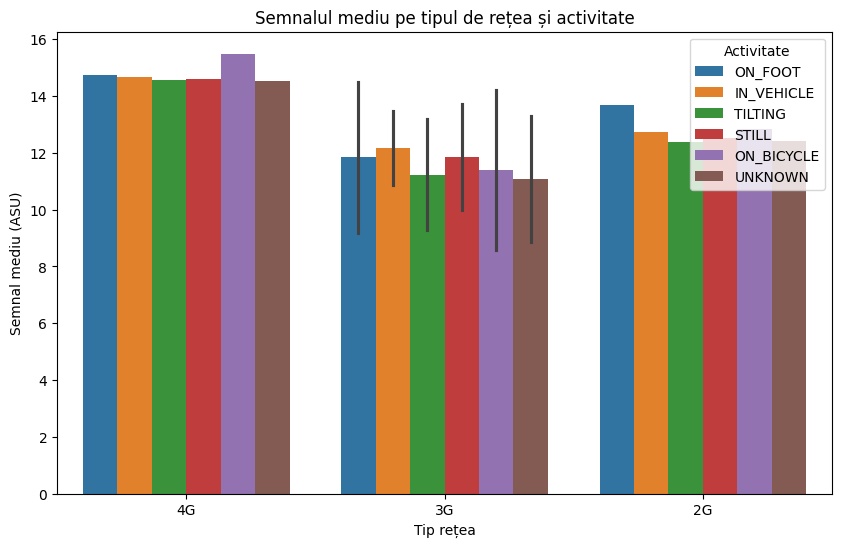

In [ ]:
# Convertim in Pandas pentru a folosi Seaborn
agg_df_pd = agg_df.toPandas()

# Graficul 1: Relatia intre tipul de retea si semnalul mediu
plt.figure(figsize=(10, 6))
sns.barplot(x="net", y="avg_signal", hue="activity", data=agg_df_pd)
plt.title("Semnalul mediu pe tipul de rețea și activitate")
plt.xlabel("Tip rețea")
plt.ylabel("Semnal mediu")
plt.legend(title="Activitate")
plt.show()

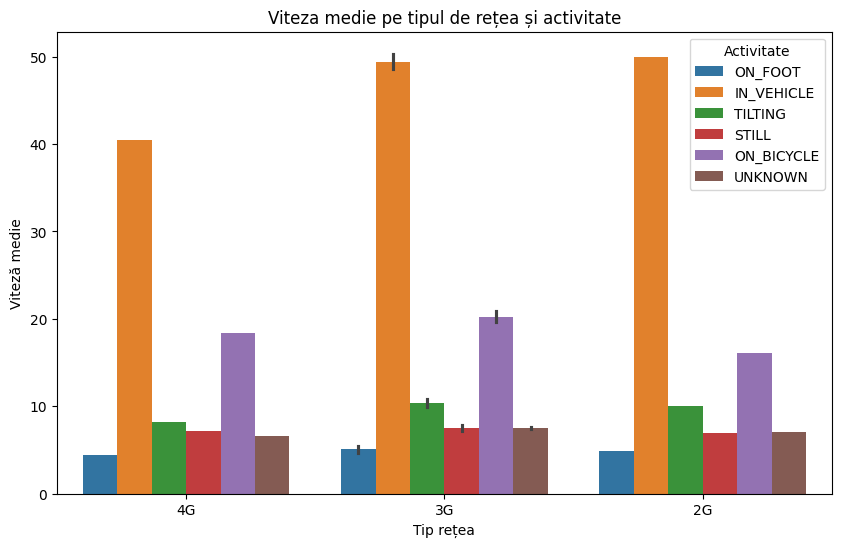

In [ ]:
# Graficul 2: Viteza medie in functie de tipul de retea si activitate
plt.figure(figsize=(10, 6))
sns.barplot(x="net", y="avg_speed", hue="activity", data=agg_df_pd)
plt.title("Viteza medie pe tipul de rețea și activitate")
plt.xlabel("Tip rețea")
plt.ylabel("Viteză medie")
plt.legend(title="Activitate")
plt.show()

In [ ]:
model_df = spark_df.select("signal", "speed").na.drop()

# Pregatire date pentru model: `signal` este caracteristica si `speed` este variabila tinta
vectorAssembler = VectorAssembler(inputCols=["signal"], outputCol="features")
model_df = vectorAssembler.transform(model_df).select("features", "speed")

train_data, test_data = model_df.randomSplit([0.8, 0.2])

# Antren. modelul de regresie liniara
lr = LinearRegression(featuresCol="features", labelCol="speed")
lr_model = lr.fit(train_data)

# Afis coef.
print(f"Intercept: {lr_model.intercept}")
print(f"Coefficients: {lr_model.coefficients}")

# Evaluare model
test_results = lr_model.evaluate(test_data)
print(f"RMSE: {test_results.rootMeanSquaredError}")
print(f"R2: {test_results.r2}")

Intercept: 29.115184495339534
Coefficients: [-0.12836049411724118]
RMSE: 35.99988763103
R2: 0.0006649664272653233


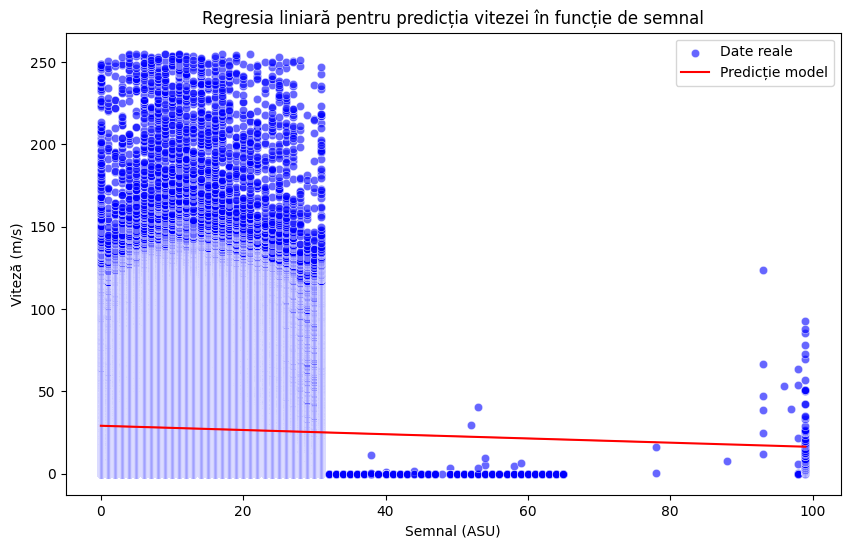

In [ ]:
# Generare predicții pentru setul de date de test
predictions = lr_model.transform(test_data)

# Convertire in Pandas DataFrame pentru a crea graficul
predictions_pd = predictions.select("features", "speed", "prediction").toPandas()
predictions_pd["signal"] = predictions_pd["features"].apply(lambda x: float(x[0]))  # Extragem valoarea `signal` din vector

plt.figure(figsize=(10, 6))
sns.scatterplot(x="signal", y="speed", data=predictions_pd, label="Date reale", color="blue", alpha=0.6)
sns.lineplot(x="signal", y="prediction", data=predictions_pd, label="Predicție model", color="red")

plt.title("Regresia liniară pentru predicția vitezei în funcție de semnal")
plt.xlabel("Semnal (ASU)")
plt.ylabel("Viteză")
plt.legend()
plt.show()

In [ ]:
query = """
    SELECT date, hour, lat, long, signal, net, speed, status, activity
    FROM `bigquery-public-data.catalonian_mobile_coverage_eu.mobile_data_2015_2017`
    WHERE speed is not null and date between '2015-01-01' and '2015-12-31'
"""

query_job = client.query(query)
df = query_job.result().to_dataframe()

print(df.head())

         date      hour       lat      long  signal   net  speed  status  \
0  2015-06-08  19:35:22  41.38193   2.02938      19    2G   91.0       3   
1  2015-06-08  19:11:59  41.62085   2.58525       6  None   42.2       3   
2  2015-06-08  13:18:26  41.67867   1.84706      20  None   58.2       3   
3  2015-06-08  11:20:06  41.80480   0.87802       2  None    5.9       3   
4  2015-06-08  05:11:01  26.66950 -81.82933       9  None    0.2       3   

     activity  
0  IN_VEHICLE  
1  IN_VEHICLE  
2  IN_VEHICLE  
3  IN_VEHICLE  
4     TILTING  


In [ ]:
df['hour'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str))

In [ ]:
spark = SparkSession.builder.appName("BigQueryAnalysis").getOrCreate()

spark_df = spark.createDataFrame(df)
spark_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- signal: long (nullable = true)
 |-- net: string (nullable = true)
 |-- speed: double (nullable = true)
 |-- status: long (nullable = true)
 |-- activity: string (nullable = true)



In [ ]:
from pyspark.sql.functions import when, lit

spark_df = spark_df.withColumn("net", when(spark_df["net"].isNull(), lit("3G")).otherwise(spark_df["net"]))

spark_df = spark_df.withColumn("speed", when(spark_df["speed"].isNull(), lit(0)).otherwise(spark_df["speed"]))
spark_df = spark_df.withColumn("signal", when(spark_df["signal"].isNull(), lit(0)).otherwise(spark_df["signal"]))

In [ ]:
spark_df = spark_df.limit(1000000)

Root Mean Squared Error (RMSE) pentru Random Forest: 30.239620754907836
+-------------+-----+------------------+
|     features|speed|        prediction|
+-------------+-----+------------------+
|    (8,[],[])|  0.9|13.707638653368136|
|    (8,[],[])|  2.9|13.707638653368136|
|    (8,[],[])|  3.7|13.707638653368136|
|    (8,[],[])|  7.5|13.707638653368136|
|    (8,[],[])| 18.8|13.707638653368136|
|(8,[0],[1.0])|  0.8|13.707638653368136|
|(8,[0],[1.0])|  2.6|13.707638653368136|
|(8,[0],[1.0])|  3.7|13.707638653368136|
|(8,[0],[1.0])|  9.6|13.707638653368136|
|(8,[0],[1.0])| 11.1|13.707638653368136|
|(8,[0],[1.0])| 11.7|13.707638653368136|
|(8,[0],[1.0])| 12.2|13.707638653368136|
|(8,[0],[1.0])| 15.0|13.707638653368136|
|(8,[0],[1.0])| 15.5|13.707638653368136|
|(8,[0],[1.0])| 15.8|13.707638653368136|
|(8,[0],[1.0])| 16.9|13.707638653368136|
|(8,[0],[1.0])| 19.5|13.707638653368136|
|(8,[0],[1.0])| 20.7|13.707638653368136|
|(8,[0],[1.0])| 21.4|13.707638653368136|
|(8,[0],[1.0])| 35.0|13.70

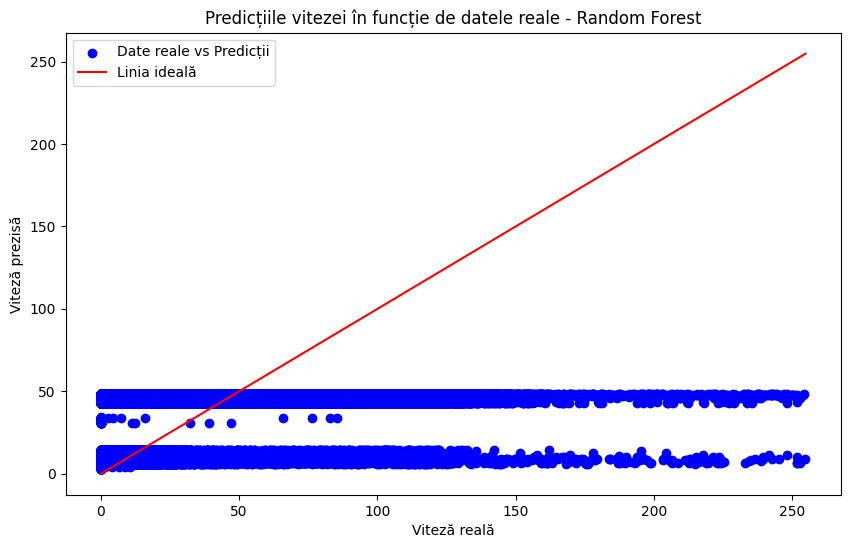

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Index. coloanele categorice (daca `net` si `activity` sunt categorice)
indexer_net = StringIndexer(inputCol="net", outputCol="netIndex")
indexer_activity = StringIndexer(inputCol="activity", outputCol="activityIndex")

# Aplicare one-hot encoding
encoder_net = OneHotEncoder(inputCol="netIndex", outputCol="netVec")
encoder_activity = OneHotEncoder(inputCol="activityIndex", outputCol="activityVec")

# VectorAssembler pentru a combina caracteristicile intr-un singur vector
vectorAssembler = VectorAssembler(inputCols=["signal", "netVec", "activityVec"], outputCol="features")

spark_df_indexed = indexer_net.fit(spark_df).transform(spark_df)
spark_df_indexed = indexer_activity.fit(spark_df_indexed).transform(spark_df_indexed)

# Apply OneHotEncoder transformations before passing to VectorAssembler
spark_df_indexed = encoder_net.fit(spark_df_indexed).transform(spark_df_indexed) # Applying OneHotEncoder for 'net'
spark_df_indexed = encoder_activity.fit(spark_df_indexed).transform(spark_df_indexed) # Applying OneHotEncoder for 'activity'

model_df_rf = vectorAssembler.transform(spark_df_indexed).select("features", "speed").na.drop()

# impartire date in set antrenament si testare
train_data_rf, test_data_rf = model_df_rf.randomSplit([0.8, 0.2])

# antrenare Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="speed")
rf_model = rf.fit(train_data_rf)

# eval. model
predictions_rf = rf_model.transform(test_data_rf)
evaluator = RegressionEvaluator(labelCol="speed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_rf)
print(f"Root Mean Squared Error (RMSE) pentru Random Forest: {rmse}")

# Afisare predictii
predictions_rf.select("features", "speed", "prediction").show()

# vizualizare predictii
import matplotlib.pyplot as plt

# Extragem datele pentru vizualizare
pandas_pred_rf = predictions_rf.select("speed", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(pandas_pred_rf["speed"], pandas_pred_rf["prediction"], color="blue", label="Date reale vs Predicții")
plt.plot([pandas_pred_rf["speed"].min(), pandas_pred_rf["speed"].max()],
         [pandas_pred_rf["speed"].min(), pandas_pred_rf["speed"].max()], color="red", label="Linia ideală")
plt.xlabel("Viteză reală")
plt.ylabel("Viteză prezisă")
plt.title("Predicțiile vitezei în funcție de datele reale - Random Forest")
plt.legend()
plt.show()
